In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba  # for tokenization
from gensim.models import KeyedVectors  # for training word vector
import warnings
warnings.filterwarnings("ignore")
import bz2  # for unpacking

In [13]:
# decompress word vector
with open("用Tensorflow进行中文自然语言处理分类实践/sgns.zhihu.bigram", 'wb') as new_file, \
        open("用Tensorflow进行中文自然语言处理分类实践/sgns_zhihu_bigram_bz2", 'rb') as file:
    decompressor = bz2.BZ2Decompressor()
    for data in iter(lambda : file.read(100 * 1024), b''):
        new_file.write(decompressor.decompress(data))

In [15]:
# use gensim to load the pretrained word embedding
cn_model = KeyedVectors.load_word2vec_format('用Tensorflow进行中文自然语言处理分类实践/sgns.zhihu.bigram',
                                             binary=False, unicode_errors="ignore")

In [16]:
# The length of word vector is 300
embedding_dim = cn_model['山东大学'].shape[0]
print('词向量的长度为{}'.format(embedding_dim))
cn_model['山东大学']

词向量的长度为300


array([-2.603470e-01,  3.677500e-01, -2.379650e-01,  5.301700e-02,
       -3.628220e-01, -3.212010e-01, -1.903330e-01,  1.587220e-01,
       -7.156200e-02, -4.625400e-02, -1.137860e-01,  3.515600e-01,
       -6.408200e-02, -2.184840e-01,  3.286950e-01, -7.110330e-01,
        1.620320e-01,  1.627490e-01,  5.528180e-01,  1.016860e-01,
        1.060080e-01,  7.820700e-01, -7.537310e-01, -2.108400e-02,
       -4.758250e-01, -1.130420e-01, -2.053000e-01,  6.624390e-01,
        2.435850e-01,  9.171890e-01, -2.090610e-01, -5.290000e-02,
       -7.969340e-01,  2.394940e-01, -9.028100e-02,  1.537360e-01,
       -4.003980e-01, -2.456100e-02, -1.717860e-01,  2.037790e-01,
       -4.344710e-01, -3.850430e-01, -9.366000e-02,  3.775310e-01,
        2.659690e-01,  8.879800e-02,  2.493440e-01,  4.914900e-02,
        5.996000e-03,  3.586430e-01, -1.044960e-01, -5.838460e-01,
        3.093280e-01, -2.828090e-01, -8.563400e-02, -5.745400e-02,
       -2.075230e-01,  2.845980e-01,  1.414760e-01,  1.678570e

In [19]:
# calculate similarity
cn_model.similarity('橘子', '橙子')

0.66128117

In [23]:
# calculate similarity by hand
# dot ('橘子'/|'橘子'|, '橙子'/|'橙子'|)
np.dot(cn_model['橘子']/np.linalg.norm(cn_model['橘子']), cn_model['橙子']/np.linalg.norm(cn_model(['橙子'])))

TypeError: 'KeyedVectors' object is not callable

In [18]:
# find most similar words using cosine similarity
cn_model.most_similar(positive=['大学'],topn=10)

[('高中', 0.724782407283783),
 ('本科', 0.6768534779548645),
 ('研究生', 0.6244412064552307),
 ('中学', 0.6088204383850098),
 ('大学本科', 0.5959085822105408),
 ('初中', 0.5883589386940002),
 ('读研', 0.5778335928916931),
 ('职高', 0.5767995715141296),
 ('大学毕业', 0.5767451524734497),
 ('师范大学', 0.5708828568458557)]

In [24]:
# find distinct word
test_words = '老师 会计师 程序员 律师 医生 老人'
test_words_result = cn_model.doesnt_match(test_words.split())
print('不是一类的词为 '+test_words_result)

不是一类的词为 老人


In [29]:
# analogy
# cn_model.most_similar(positive=['女人','劈腿'], negative=['男人'], topn=1)
cn_model.most_similar(positive=['语言','奇妙'], negative=['数学'],topn=1)

[('妙不可言', 0.43668583035469055)]

### corpus source: hotel review, total: 4000 txt sample ###

In [37]:
import os
pos_txts = os.listdir('用Tensorflow进行中文自然语言处理分类实践/pos')
neg_txts = os.listdir('用Tensorflow进行中文自然语言处理分类实践/neg')

In [40]:
print("total sample is " + str(len(pos_txts) + len(neg_txts)))

total sample is 4000


In [43]:
# store all sample into a list
train_texts_orig = []

train_target = []
with open("用Tensorflow进行中文自然语言处理分类实践/positive_samples.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        dic = eval(line)
        train_texts_orig.append(dic["text"])
        train_target.append(dic["label"])

with open("用Tensorflow进行中文自然语言处理分类实践/negative_samples.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        dic = eval(line)
        train_texts_orig.append(dic["text"])
        train_target.append(dic["label"])

In [44]:
len(train_texts_orig)

4000

In [77]:
# use keras to build the model
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [47]:
# tokenization
train_tokens = []
for text in train_texts_orig:
    # remove punctuation
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # tokenize
    cut = jieba.cut(text)
    # the output is a generator
    # convert generator to list
    cut_list = [ i for i in cut ]
    for i, word in enumerate(cut_list):
        try:
            # convert word to index
            cut_list[i] = cn_model.key_to_index[word]
        except KeyError:
            # if word not in dict, return 0
            cut_list[i] = 0
    train_tokens.append(cut_list)

**normalize the index cuz the length of every review is different**

In [50]:
# length of all tokens
num_tokens = [ len(tokens) for tokens in train_tokens ]
num_tokens = np.array(num_tokens)

In [51]:
# mean of length
np.mean(num_tokens)

71.42575

In [52]:
# the max length
np.max(num_tokens)

1540

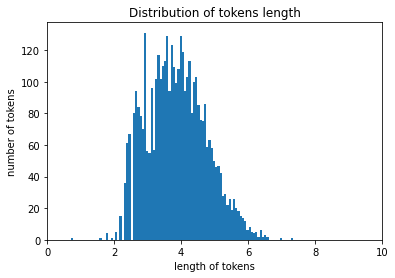

In [53]:
# the distribution of text length
plt.hist(np.log(num_tokens), bins = 100)
plt.xlim((0,10))
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [54]:
# mean +- two stds
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

236

In [55]:
# more then 95% of samples are less than 236
np.sum( num_tokens < max_tokens ) / len(num_tokens)

0.9565

In [62]:
# convert index back to text
def reverse_tokens(tokens):
    text = ''
    for i in tokens:
        if i != 0:
            text = text + cn_model.index_to_key[i]
        else:
            text = text + ' '
    return text

In [64]:
reverse = reverse_tokens(train_tokens[0])
reverse

'早餐太差无论去多少人那边也不加食品的酒店应该重视一下这个问题了房间本身很好'

In [65]:
# the original text
train_texts_orig[0]

'早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。\n\n房间本身很好。'

In [66]:
# initialize the vector
embedding_dim

300

In [68]:

num_words = 50000
embedding_matrix = np.zeros((num_words, embedding_dim))
# embedding_matrix = [num_words，embedding_dim]
# dimention = 50000 * 300
for i in range(num_words):
    embedding_matrix[i, :] = cn_model[cn_model.index_to_key[i]]
embedding_matrix = embedding_matrix.astype('float32')

In [70]:
np.sum( cn_model[cn_model.index_to_key[333]] == embedding_matrix[333] )

300

In [71]:
# dimension of embedding matrix
embedding_matrix.shape

(50000, 300)

**padding and truncating**

In [74]:
# input: list   output: numpy array
train_pad = pad_sequences(train_tokens, maxlen=max_tokens,
                            padding='pre', truncating='pre')

NameError: name 'pad_sequences' is not defined

In [75]:
# replace the words that more than 50000 with zero
train_pad[ train_pad>=num_words ] = 0

NameError: name 'train_pad' is not defined

In [ ]:
train_pad[33]

In [ ]:
# the target vectors: first 2000 are 1, the rest 2000 are 0
train_target = np.array(train_target)

In [ ]:
# 进行训练和测试样本的分割
from sklearn.model_selection import train_test_split

In [ ]:
# 90% for training set, 10% for test set
X_train, X_test, y_train, y_test = train_test_split(train_pad,
                                                    train_target,
                                                    test_size=0.1,
                                                    random_state=12)

In [ ]:
print(reverse_tokens(X_train[35]))
print('class: ',y_train[35])

In [ ]:
# Use LSTM model
model = Sequential()

In [76]:
model.add(Embedding(num_words,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_tokens,
                    trainable=False))

NameError: name 'model' is not defined

In [ ]:
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(LSTM(units=16, return_sequences=False))

In [ ]:
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(lr=1e-3)

In [76]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [76]:
model.summary()

In [76]:
path_checkpoint = 'sentiment_checkpoint.keras'
checkpoint = ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss',
                                      verbose=1, save_weights_only=True,
                                      save_best_only=True)

In [76]:
try:
    model.load_weights(path_checkpoint)
except Exception as e:
    print(e)

In [76]:
earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [76]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1, min_lr=1e-8, patience=0,
                                       verbose=1)

In [76]:
# define callback function
callbacks = [
    earlystopping,
    checkpoint,
    lr_reduction
]

In [82]:
model.fit(X_train, y_train,
          validation_split=0.1,
          epochs=20,
          batch_size=128,
          callbacks=callbacks)

NameError: name 'model' is not defined

In [82]:
result = model.evaluate(X_test, y_test)
print('Accuracy:{0:.2%}'.format(result[1]))

In [ ]:
def predict_sentiment(text):
    print(text)
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    cut = jieba.cut(text)
    cut_list = [ i for i in cut ]
    # tokenize
    for i, word in enumerate(cut_list):
        try:
            cut_list[i] = cn_model.vocab[word].index
            if cut_list[i] >= 50000:
                cut_list[i] = 0
        except KeyError:
            cut_list[i] = 0
    # padding
    tokens_pad = pad_sequences([cut_list], maxlen=max_tokens,
                           padding='pre', truncating='pre')
    result = model.predict(x=tokens_pad)
    coef = result[0][0]
    if coef >= 0.5:
        print('This is a positive sentiment','output=%.2f'%coef)
    else:
        print('This is a negative sentiment','output=%.2f'%coef)

In [ ]:
test_list = [
    '酒店设施不是新的，服务态度很不好',
    '酒店卫生条件非常不好',
    '床铺非常舒适',
    '房间很凉，不给开暖气',
    '房间很凉爽，空调冷气很足',
    '酒店环境不好，住宿体验很不好',
    '房间隔音不到位' ,
    '晚上回来发现没有打扫卫生',
    '因为过节所以要我临时加钱，比团购的价格贵'
]
for text in test_list:
    predict_sentiment(text)

In [82]:
y_pred = model.predict(X_test)
y_pred = y_pred.T[0]
y_pred = [1 if p>= 0.5 else 0 for p in y_pred]
y_pred = np.array(y_pred)

In [82]:
y_actual = np.array(y_test)

In [82]:
misclassified = np.where( y_pred != y_actual )[0]

In [82]:
len(misclassified)
print(len(X_test))

In [82]:
idx=101
print(reverse_tokens(X_test[idx]))
print('预测的分类', y_pred[idx])
print('实际的分类', y_actual[idx])

In [82]:
idx=1
print(reverse_tokens(X_test[idx]))
print('预测的分类', y_pred[idx])
print('实际的分类', y_actual[idx])